STEP1.문제정의

서비스 A(2021.12.012021.12.31)와 서비스 B(2022.03.012022.03.31)의 일별 매출을 예측하시오.

In [2]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from pylab import rcParams

from sklearn import preprocessing
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from fbprophet import Prophet

from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas import Series, DataFrame

In [3]:
#STEP2. Data Collection(데이터 수집)

#import dataset
service_A=pd.read_csv("D:\kakaotech\service_A.csv",encoding='UTF8')
service_B=pd.read_csv("D:\kakaotech\service_B.csv",encoding='UTF8')

print('서비스 A: ',service_A.shape , '\n서비스 B: ', service_B.shape)

서비스 A:  (1065, 9) 
서비스 B:  (790, 9)


In [4]:
service_B.head(5)

,Unnamed: 0,날짜,feat_a,feat_b,feat_c,feat_d,feat_e,feat_f,매출
0,0,2022. 2. 28,0,302239,5794,120,9426,0,36339622
1,1,2022. 2. 27,0,216136,9346,174,7037,494882,37568748
2,2,2022. 2. 26,0,229206,7411,164,8025,494870,37568713
3,3,2022. 2. 25,0,325934,3171,115,10158,494870,37568713
4,4,2022. 2. 24,0,337694,2133,111,10049,494870,37568713


In [5]:
#STEP3. Data Exploration & Data Preprocessing(데이터 탐색 및 전처리 )
#STEP3-1. 데이터 탐색
service_B.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790 entries, 0 to 789
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  790 non-null    int64 
 1   날짜          790 non-null    object
 2   feat_a      790 non-null    int64 
 3   feat_b      790 non-null    int64 
 4   feat_c      790 non-null    int64 
 5   feat_d      790 non-null    int64 
 6   feat_e      790 non-null    int64 
 7   feat_f      790 non-null    int64 
 8   매출          790 non-null    int64 
dtypes: int64(8), object(1)
memory usage: 55.7+ KB


In [6]:
temp_B=service_B.drop('Unnamed: 0', axis=1)
temp_B

,날짜,feat_a,feat_b,feat_c,feat_d,feat_e,feat_f,매출
0,2022. 2. 28,0,302239,5794,120,9426,0,36339622
1,2022. 2. 27,0,216136,9346,174,7037,494882,37568748
2,2022. 2. 26,0,229206,7411,164,8025,494870,37568713
3,2022. 2. 25,0,325934,3171,115,10158,494870,37568713
4,2022. 2. 24,0,337694,2133,111,10049,494870,37568713
...,...,...,...,...,...,...,...,...
785,2020. 1. 5,0,352172,1785,166,2109,260743,58294387
786,2020. 1. 4,0,375048,4955,155,2146,260743,58294387
787,2020. 1. 3,0,441443,1991,132,2559,260743,58294387
788,2020. 1. 2,0,385217,2871,151,1861,260743,58294387


<AxesSubplot:xlabel='date', ylabel='매출'>

C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 47588 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 52636 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 47588 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 52636 missing from current font.
  font.set_text(s, 0, flags=flags)


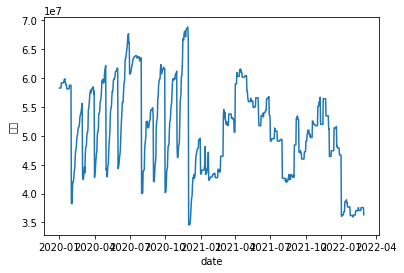

In [7]:
temp_B['date']=pd.to_datetime(temp_B['날짜'])

sns.lineplot(data=temp_B, x='date', y='매출', estimator=sum)

In [8]:
df=pd.pivot_table(data=temp_B, index='date', values='매출', aggfunc='sum').reset_index()
df

,date,매출
0,2020-01-01,58294387
1,2020-01-02,58294387
2,2020-01-03,58294387
3,2020-01-04,58294387
4,2020-01-05,58294387
...,...,...
785,2022-02-24,37568713
786,2022-02-25,37568713
787,2022-02-26,37568713
788,2022-02-27,37568748


In [29]:
#STEP3-2. missing value: dropna를 사용하여 결측값이 있는 행을 제거.
df_B=temp_B.dropna()

In [30]:
#STEP4. Modeling

#STEP4-1. dickey-fuller 단위근 검정으로 일일 매출의 정상성 여부를 점검
result=adfuller(df_B['매출'])
print(result)

(-5.02083294913489, 2.0179895871490874e-05, 2, 787, {'1%': -3.438686413400388, '5%': -2.8652194721349424, '10%': -2.5687293001910008}, 24797.164194022138)


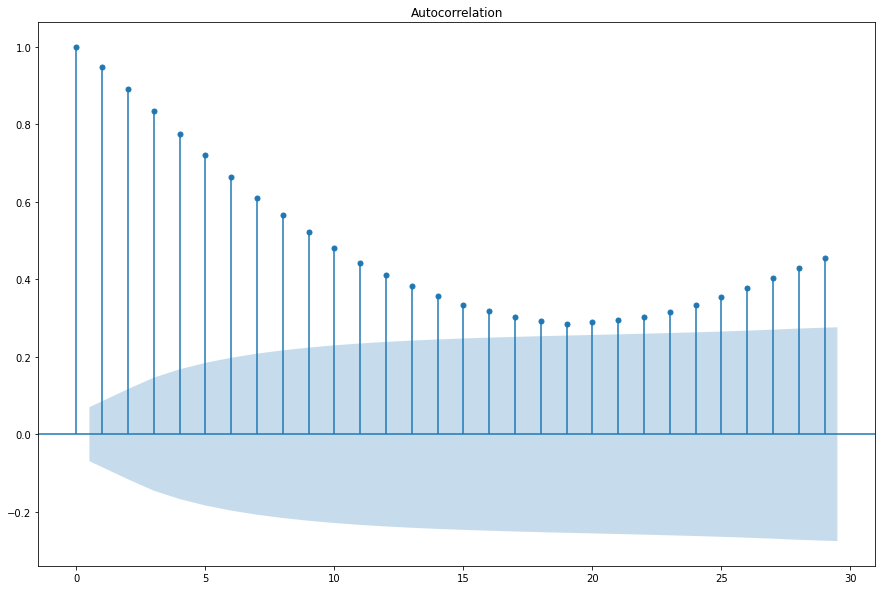

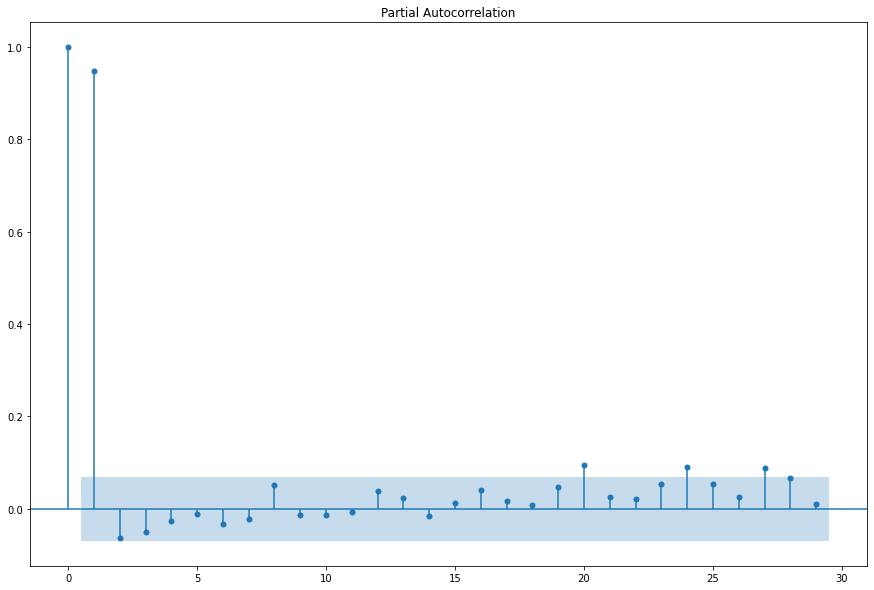

In [31]:
plot_acf(df_B['매출'])
plot_pacf(df_B['매출'])
plt.show()

ACF를 보면 자기상관이 time_lag 20을 기준으로 감소하다가 다시 증가한다(계속 양에서만 움직임). PACF는 time_lag 1과 2에서 1.0을 보이고 이후에 급격히 감소했습니다. 때문에 p=1, q=1이 적합하다고 추측했습니다.  

In [32]:
#STEP4-2.ARIMA
df2_B=pd.pivot_table(data=df, index='date', values='매출', aggfunc='sum')

df2_B.head()

,매출
date,
2020-01-01,58294387
2020-01-02,58294387
2020-01-03,58294387
2020-01-04,58294387
2020-01-05,58294387


In [33]:
y=df2_B['매출'].resample('1D').mean()

C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 47588 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 52636 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 47588 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 52636 missing from current font.
  font.set_text(s, 0, flags=flags)


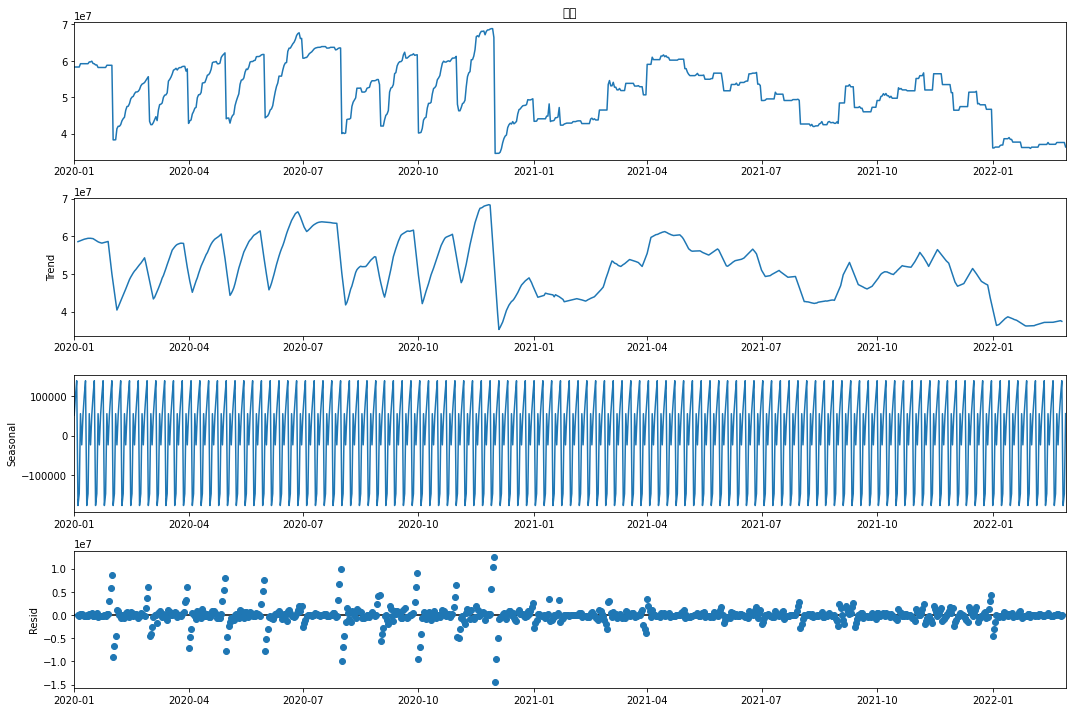

In [34]:
#시계열 모델 plot 
rcParams['figure.figsize']=15,10

model_series=tsa.seasonal_decompose (y, model='additive')
fig=model_series.plot()

plt.show()

In [15]:
#ARIMA
model_arima=tsa.statespace.SARIMAX(y, order=(1,1,1), seasonal_order=(0,1,1,12), enforce_stationalrity=False, enforce_invertibility=False)
result_arima=model_arima.fit()

print(result_arima.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3002      4.242      0.071      0.944      -8.015       8.615
ma.L1         -0.2695      4.257     -0.063      0.950      -8.614       8.075
ma.S.L12      -0.9241      0.034    -27.218      0.000      -0.991      -0.858
sigma2      1.315e+13   3.51e-11   3.75e+23      0.000    1.32e+13    1.32e+13


In [16]:
ar_p=ma_q=d=range(0,2)
pqd=list(itertools.product(ar_p, d, ma_q))
seasonal_pqd=[(x[0], x[1], x[2], 12) for x in list(itertools.product(ar_p, d, ma_q))]

seasonal_pqd #ARIMA model parameters

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [17]:
param_list=[]
param_seasonal_list=[]
result_list=[]

In [18]:
for param in pqd:
    for param_seasonal in seasonal_pqd:
        try:
            model_sa=tsa.statespace.SARIMAX(y, order=param, seasonal_order=param_seasonal,
                                                enforce_stationarity=False, enforce_invertibility=False)
            results=model_sa.fit()
            param_list.append(param)
            param_seasonal_list.append(param_seasonal)
            result_list.append(results.aic)
        except:
            continue

In [21]:
arima_list=pd.DataFrame({'Parameter': param_list, 'Seasonal': param_seasonal_list,'AIC': result_list})
arima_list.to_csv('ARIMA Model_B.csv')

In [23]:
arima_list.sort_values(by='AIC')

,Parameter,Seasonal,AIC
23,"(0, 1, 0)","(1, 1, 1, 12)",24921.169097
19,"(0, 1, 0)","(0, 1, 1, 12)",24935.670408
31,"(0, 1, 1)","(1, 1, 1, 12)",24952.975780
63,"(1, 1, 1)","(1, 1, 1, 12)",24953.418407
27,"(0, 1, 1)","(0, 1, 1, 12)",24960.733645
...,...,...,...
9,"(0, 0, 1)","(0, 0, 1, 12)",29068.190630
12,"(0, 0, 1)","(1, 0, 0, 12)",29079.174298
1,"(0, 0, 0)","(0, 0, 1, 12)",29271.542149
8,"(0, 0, 1)","(0, 0, 0, 12)",29655.087674


In [25]:
model_sarimax=tsa.statespace.SARIMAX(y, order=(0,1,0), seasonal_order=(1,1,1,12), enforce_stationarity=False, enforcce_invertibilty=False)
result_sarimax=model_sarimax.fit()

print(result_sarimax.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                   매출   No. Observations:                  790
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 12)   Log Likelihood              -12457.585
Date:                              Mon, 16 May 2022   AIC                          24921.169
Time:                                      13:29:39   BIC                          24935.085
Sample:                                  01-01-2020   HQIC                         24926.526
                                       - 02-28-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.1750      0.023     -7.748      0.000      -0.219      -0.131
ma.S.L12      -0.56

In [38]:
forecast_result=result_sarimax.forecast(steps=31)
print(forecast_result)

2022-03-01    3.608910e+07
2022-03-02    3.534894e+07
2022-03-03    3.565139e+07
2022-03-04    3.560368e+07
2022-03-05    3.570796e+07
2022-03-06    3.563138e+07
2022-03-07    3.565677e+07
2022-03-08    3.562213e+07
2022-03-09    3.565062e+07
2022-03-10    3.580474e+07
2022-03-11    3.575116e+07
2022-03-12    3.544495e+07
2022-03-13    3.523827e+07
2022-03-14    3.462762e+07
2022-03-15    3.487714e+07
2022-03-16    3.483779e+07
2022-03-17    3.501041e+07
2022-03-18    3.494723e+07
2022-03-19    3.496818e+07
2022-03-20    3.493960e+07
2022-03-21    3.496311e+07
2022-03-22    3.509026e+07
2022-03-23    3.504606e+07
2022-03-24    3.457836e+07
2022-03-25    3.436400e+07
2022-03-26    3.373069e+07
2022-03-27    3.398947e+07
2022-03-28    3.394866e+07
2022-03-29    3.410932e+07
2022-03-30    3.404380e+07
2022-03-31    3.406552e+07
Freq: D, Name: predicted_mean, dtype: float64


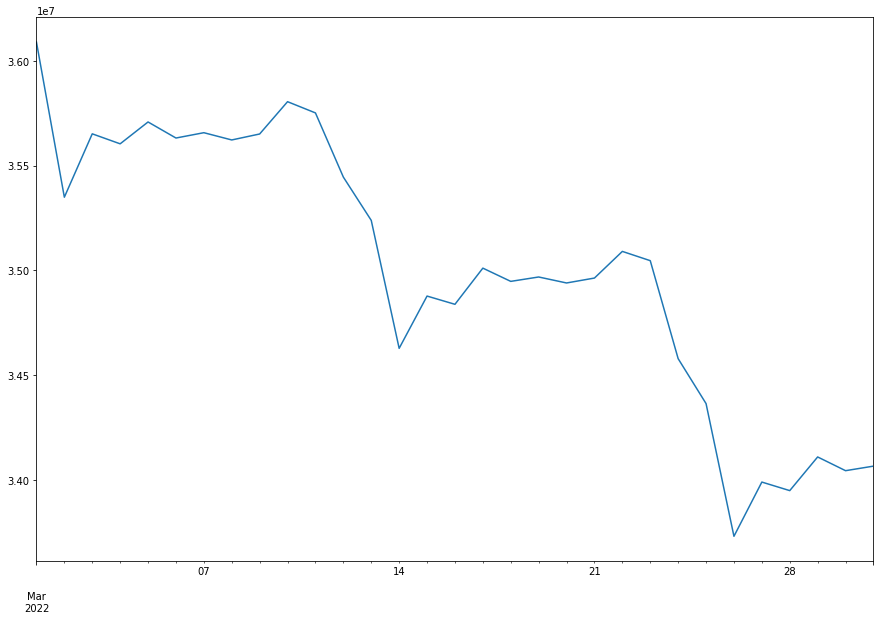

In [39]:
fore_plt=forecast_result.plot()

plt.show()

In [40]:
forecast_result.to_csv('Service_B_predict.csv')

In [52]:
#STEP5. Model 성능 확인
df2_B['forecast']=result_sarimax.predict(start=50, end=200)

<AxesSubplot:xlabel='date'>

C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 47588 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 52636 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 47588 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 52636 missing from current font.
  font.set_text(s, 0, flags=flags)


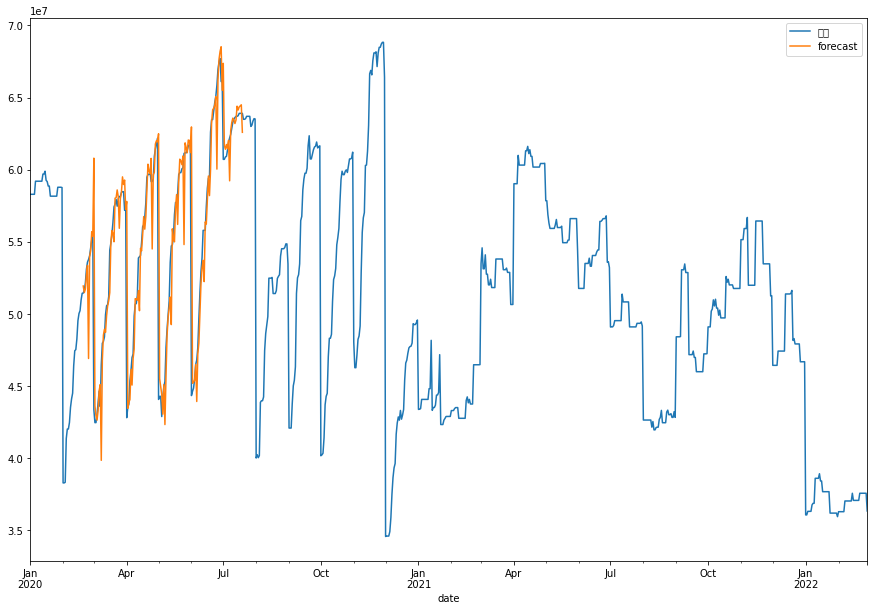

In [53]:
df2_B[['매출', 'forecast']].plot()

C:\Users\user\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 47588 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 47588 missing from current font.
  font.set_text(s, 0, flags=flags)


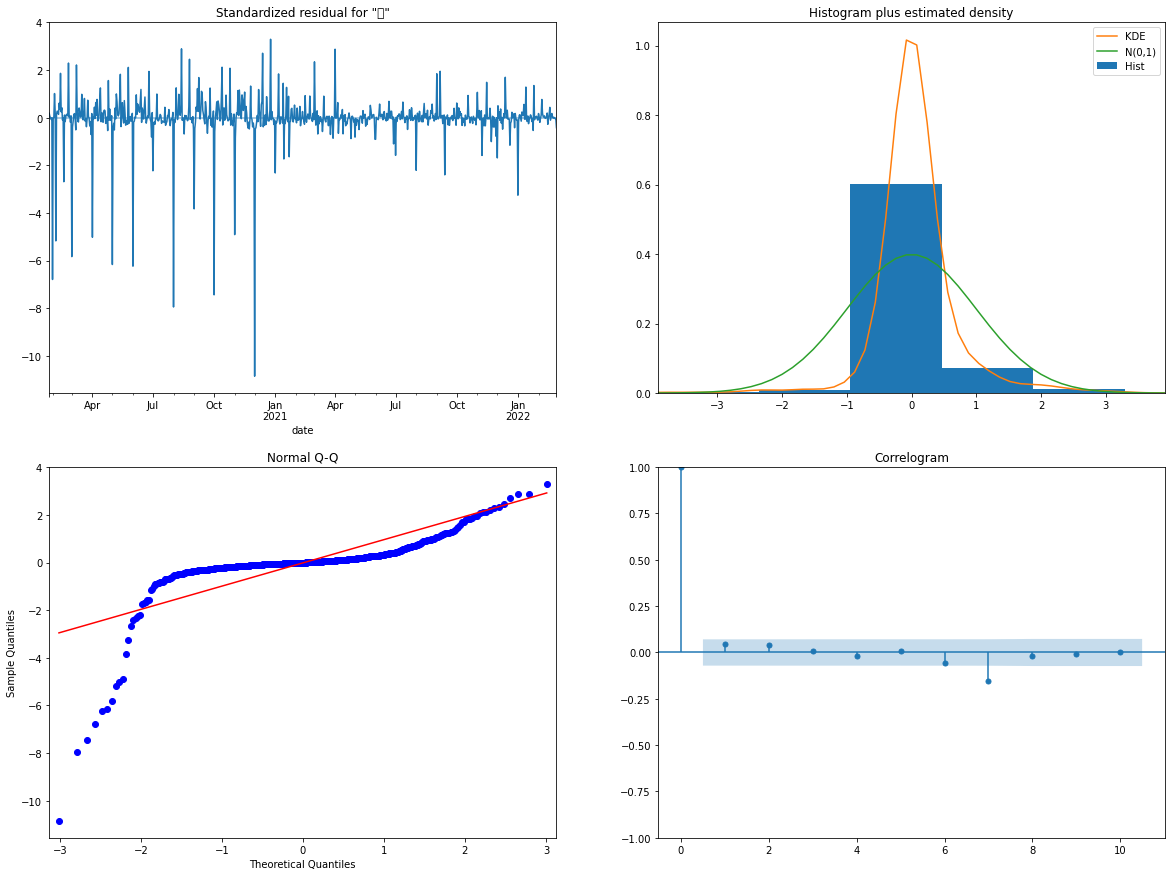

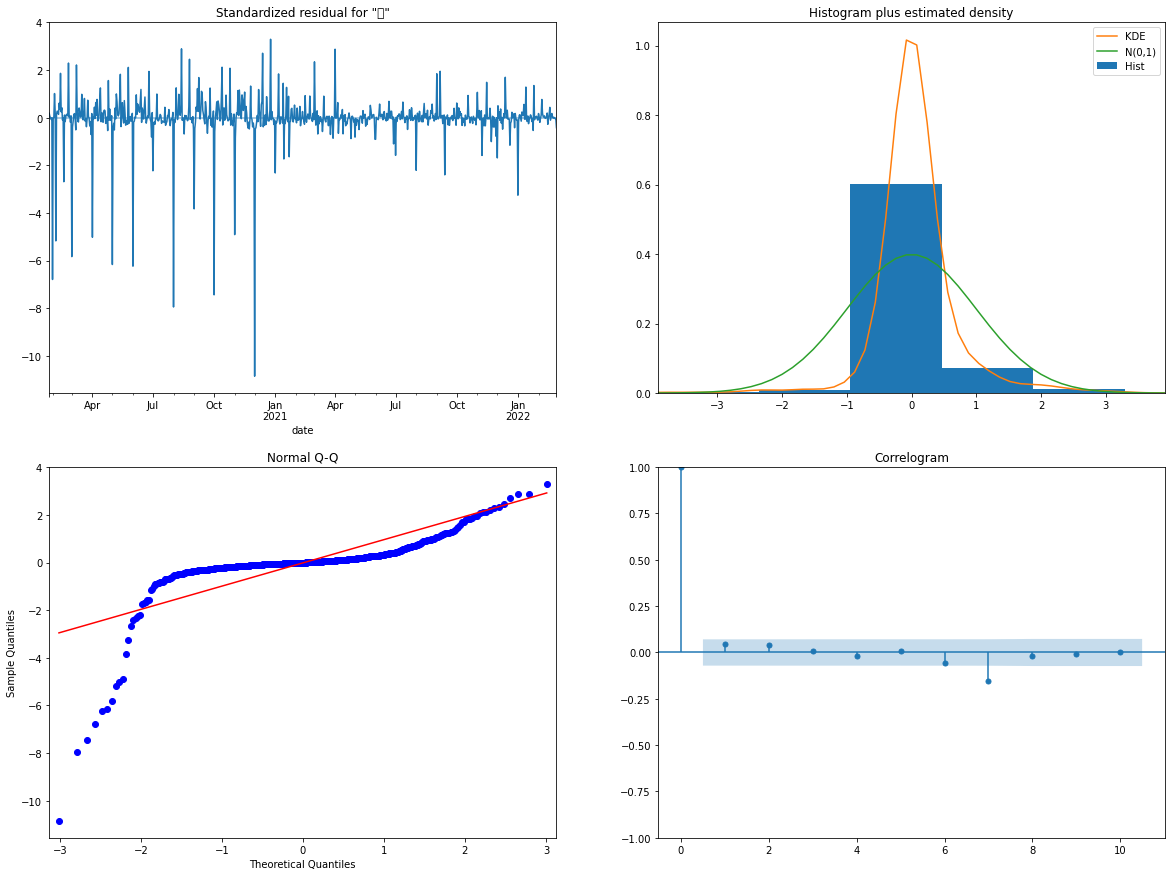

In [54]:
rcParams['figure.figsize']=20,15

result_sarimax.plot_diagnostics()